Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)
* textos_de_los_tweets_en_campaña_2016.csv

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(42)

## Setup

In [6]:
YEAR='2018'
WIKILM_PATH=Path('./WIKI_LM/LM')
DATA_PATH=Path('./DATA/'+YEAR)
FINETUNE_PATH=Path('./FINETUNE/'+YEAR)

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Prepare Data

In [8]:
df_1 = pd.read_csv(DATA_PATH/'train.csv', header=None)
df_2 = pd.read_csv(DATA_PATH/'general.csv', header=None)

In [9]:
tweets_1 = df_1[1].values
tweets_2 = df_2[1].values

In [10]:
len(tweets_1)

1000

In [11]:
tweets = np.concatenate([tweets_1, tweets_1, tweets_2])
del df_1, df_2, tweets_1, tweets_2

In [12]:
np.random.shuffle(tweets)
tweets_sampled = tweets.copy()

In [13]:
tweets_sampled[:5]

array(['Ya!',
       '#investidurarajoy comienzan las intervenciones del Grupo Mixto. Sube como portavoz de Amaiur, iñaki Antigüedad.',
       '#OscarCanalPlus pero me muero de sueño y mañana tengo que madrugar :(',
       'El rey acaba de poner a Urdangarin a los pies de la Justicia #discursodelRey',
       '@ximealomia @RPPNoticias @Radio_Oxigeno la que acabo de poner es peor'], dtype=object)

In [14]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

import unicodedata

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Remove \n
    tweets = np.array([str(i).replace('\n','') for i in tweets])
    tweets = np.array([str(i).replace('&lt;','') for i in tweets])
    tweets = np.array([str(i).replace('&gt;','') for i in tweets])
    
    # Remove accents
    tweets = np.array([strip_accents(i) for i in tweets])
    
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'hyp_link' if i.startswith('.http') 
               else 'user_ref' if i.startswith('@')
               else 'hash_tag' if i.startswith('#')
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string'] if isInt(i) 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que'] if i in ['q', 'k', 'qu', 'ke', 'qe'] 
               else ['por'] if i=='x' 
               else ['porque'] if i in ['xq', 'pq', 'porq'] 
               else ['de'] if i=='d' 
               else ['te'] if i=='t'
               else ['también'] if i=='tb'
               else ['Que'] if i in ['Q', 'K', 'Qu','Ke', 'Qe'] 
               else ['Por'] if i=='X'
               else ['Porque'] if i in ['Xq', 'Pq', 'Porq'] 
               else ['De'] if i=='D' 
               else ['Te'] if i=='T'
               else ['También'] if i=='Tb'
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju'),
               ('risa_ja','aj'), ('risa_ji','ij'), ('risa_ju', 'uj'), ('risa_ja', 'lol')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

    return tweets


In [15]:
tweets_sampled = preprocess_tweets(tweets_sampled)

In [16]:
tweets_sampled[:5]

array(['Ya!',
       'hash_tag comienzan las intervenciones del Grupo Mixto. Sube como portavoz de Amaiur, inaki Antiguedad.',
       'hash_tag pero me muero de sueno y manana tengo que madrugar :(',
       'El rey acaba de poner a Urdangarin a los pies de la Justicia hash_tag',
       'user_ref user_ref user_ref la que acabo de poner es peor'], dtype='<U198')

In [17]:
train_limit = int(len(tweets_sampled)*0.9)

In [18]:
col_names = ['label', 'tweet']
df_trn = pd.DataFrame({'tweet':tweets_sampled[:train_limit], 'label':[0]*len(tweets_sampled[:train_limit])},
                      columns=col_names)

df_val = pd.DataFrame({'tweet':tweets_sampled[train_limit:], 'label':[0]*len(tweets_sampled[train_limit:])},
                      columns=col_names)

In [19]:
df_trn.to_csv(FINETUNE_PATH/'train.csv', header=False, index=False)
df_val.to_csv(FINETUNE_PATH/'validation.csv', header=False, index=False)

## Tokenize and Standarize General Tokens


In [20]:
chunksize=24000

re1 = re.compile(r'  +')

In [21]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [22]:
df_trn = pd.read_csv(FINETUNE_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(FINETUNE_PATH/'validation.csv', header=None, chunksize=chunksize)

In [23]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [24]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(8296, 8296, 922, 922)

In [25]:
print(tok_trn[:2])

[['\n', 'xbos', 'ya', '!'], ['\n', 'xbos', 'hash_tag', 'comienzan', 'las', 'intervenciones', 'del', 'grupo', 'mixto', '.', 'sube', 'como', 'portavoz', 'de', 'amaiur', ',', 'inaki', 'antiguedad', '.']]


In [26]:
(FINETUNE_PATH/'tmp').mkdir(exist_ok=True)

In [27]:
np.save(FINETUNE_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(FINETUNE_PATH/'tmp'/'tok_val.npy', tok_val)

In [28]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 8296),
 ('xbos', 8296),
 ('de', 6259),
 ('.', 4756),
 ('user_ref', 4361),
 ('la', 3929),
 (',', 3897),
 ('que', 3825),
 ('el', 3578),
 ('en', 3223),
 ('a', 3166),
 ('y', 3062),
 ('!', 2531),
 ('hyp_link', 2281),
 ('hash_tag', 1749),
 ('no', 1742),
 ('"', 1716),
 ('t_up', 1534),
 ('los', 1432),
 ('un', 1308)]

In [29]:
max_vocab = 60000
min_freq = 2

In [30]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

4683

In [31]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [32]:
np.save(FINETUNE_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(FINETUNE_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(FINETUNE_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [33]:
BACKBONE_MODEL = WIKILM_PATH/'models/lm1_weights.h5'

In [34]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [35]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [36]:
itos2 = pickle.load((WIKILM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [37]:
em_sz,nh,nl = 400,1150,3

In [38]:
trn_lm = np.load(FINETUNE_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(FINETUNE_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(FINETUNE_PATH/'tmp'/'itos.pkl', 'rb'))

In [39]:
vs=len(itos)
vs,len(trn_lm)

(4683, 8296)

In [40]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [41]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [42]:
wd=1e-7
bptt=70
bs=64
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [43]:
trn_lm = np.load(FINETUNE_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(FINETUNE_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [44]:
itos = pickle.load(open(FINETUNE_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(FINETUNE_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [45]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [46]:
learn = md.get_model(opt_fn, em_sz, nh, nl, dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [47]:
learn.model.load_state_dict(wgts)

In [91]:
learn.load('lm1_wgts')

RuntimeError: While copying the parameter named 0.encoder.weight, whose dimensions in the model are torch.Size([7197, 400]) and whose dimensions in the checkpoint are torch.Size([4686, 400]).

In [48]:
# %debug
learn.lr_find2(start_lr=1e-1,end_lr=20e-1, num_it=300)

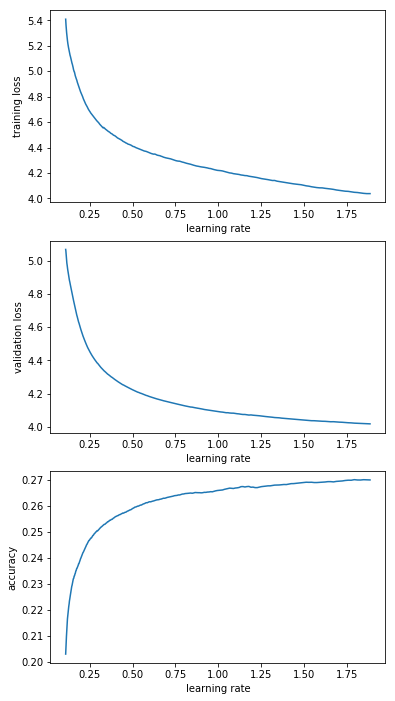

In [49]:
learn.sched.plot()

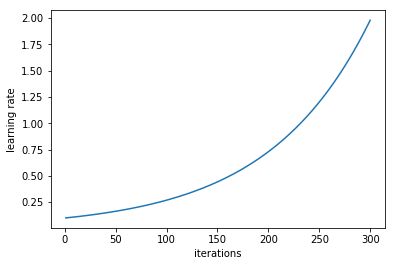

In [94]:
learn.sched.plot_lr()

In [50]:
lr= 100e-2
lrs = lr

In [51]:
learn.clip=0.12

In [52]:
learn.fit(lr, 3, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy   
    0      5.209957   4.700922   0.238385  
    1      4.822234   4.287461   0.254026  
    2      4.575487   4.17834    0.261406  
    3      4.421796   4.108721   0.266633  
    4      4.312794   4.078682   0.266198  
    5      4.237207   4.056133   0.269236  
    6      4.170323   4.04617    0.269613  
    7      4.124697   4.034219   0.271077  
    8      4.092342   4.030805   0.271031  
    9      4.092577   4.028573   0.271665  
    10     4.070756   4.01655    0.272811  
    11     4.04572    4.007859   0.270593  
    12     4.008325   3.969653   0.276294  
    13     3.965238   3.969508   0.277505  
    14     3.918614   3.963065   0.274588  
    15     3.867778   3.954283   0.278926  
    16     3.817588   3.92993    0.281599  
    17     3.804288   3.944141   0.281381  
    18     3.776654   3.925849   0.280804  
    19     3.755932   3.928378   0.283659  
    20     3.747524   3.932196   0.282497  
    21     3.731276   3.933727 

[array([3.89435]), 0.2874436954388747]

In [53]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')